In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm


In [45]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'Ready1'
runName='TestRun1'
region='himalayas'
size = 100000

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataset, region)
bbx = json.loads(bbx)
maxY=bbx['gridCellMaxY']
minT = datetime.datetime.utcfromtimestamp(bbx['minTime']) # divide by 1000 because it is in milliseconds
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":400000,"gridCellMaxX":800000,"gridCellMinY":0,"gridCellMaxY":200000,"minTime":1279306567,"maxTime":1556036317,"totalPoints":86809,"numberOfShards":4}


In [46]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx_filtered
0,400000,0,100000,1.800890,164.495799,559,-15.102616,33,445452.991243,39138.013820,...,-8.099539,-28.367860,-11.581904,-19.933738,-12.577619,-2.202863,-31.617558,-15.910231,559,2217638
1,500000,0,100000,9.362339,762.097302,84381,-5.871442,395,525800.639277,27433.554758,...,-2.112782,-4.580646,-5.089044,-7.117132,-7.885725,-11.130472,-11.537673,-10.002011,84381,2104000
2,700000,0,100000,1.455489,134.524963,1692,-6.824916,6,742012.231640,10649.710277,...,-0.901088,-20.949844,-9.986534,-13.761399,-10.480325,-5.783403,13.845252,0.000000,1692,1873381
3,500000,100000,100000,0.238513,33.267360,177,-31.560871,0,507960.936709,164958.351801,...,-90.146607,-41.896099,-48.027366,-22.803770,-14.117469,-5.892263,-20.976404,0.000000,177,3975162


In [47]:
# convert center points to geo points
crs = json.loads(query.getProjection(parentDsName, region))['proj4']

def toGeoData(data):
    # Convert gridcells to point geometries in the middle of the cell
    geometry = [Point(xy) for xy in zip(data['gridCell.minX']+(size/2), data['gridCell.minY']+(size/2))]
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

dfStats = toGeoData(dfStats.copy())

In [26]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx_filtered,geometry
0,400000,0,100000,1.800890,164.495799,559,-15.102616,33,445452.991243,39138.013820,...,-28.367860,-11.581904,-19.933738,-12.577619,-2.202863,-31.617558,-15.910231,559,2217638,POINT (450000 50000)
1,500000,0,100000,9.362339,762.097302,84381,-5.871442,395,525800.639277,27433.554758,...,-4.580646,-5.089044,-7.117132,-7.885725,-11.130472,-11.537673,-10.002011,84381,2104000,POINT (550000 50000)
2,700000,0,100000,1.455489,134.524963,1692,-6.824916,6,742012.231640,10649.710277,...,-20.949844,-9.986534,-13.761399,-10.480325,-5.783403,13.845252,0.000000,1692,1873381,POINT (750000 50000)
3,500000,100000,100000,0.238513,33.267360,177,-31.560871,0,507960.936709,164958.351801,...,-41.896099,-48.027366,-22.803770,-14.117469,-5.892263,-20.976404,0.000000,177,3975162,POINT (550000 150000)


In [48]:
def addColumns(dfCell):
    #year, month, day, dateobject = [], [], [], []
    # xdiff and ydiff are relative x and y positions to the centre
    xdiff, ydiff = [], []
    # glacial year
    gla_year = []
    for i, row in dfCell.iterrows():
        date = datetime.datetime.utcfromtimestamp(dfCell.time[i])
        #year.append(date.year)
        #month.append(date.month)
        #day.append(date.day)
        #dateobject.append(date)
        #yearmonth.append('%s-%s' % (date.year, date.month))
        # x and y distance to center point of gridcell
        xdiff.append((dfCell.x[i] % size) - (size/2))
        ydiff.append((dfCell.y[i] % size) - (size/2))
        if date.month < 10:
            gla_year.append(date.year)
        else:
            gla_year.append(date.year+1)

    dfCell['gla_year'] = gla_year
    #dfCell['year'], dfCell['month'], dfCell['day'] = year, month, day
    #dfCell['dateobject'] = dateobject
    #dfCell['yearmonth'] = yearmonth
    dfCell['offsetX'], dfCell['offsetY'] = xdiff, ydiff
    return dfCell


In [7]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx_filtered,geometry
0,400000,0,100000,1.800890,164.495799,559,-15.102616,33,445452.991243,39138.013820,...,-28.367860,-11.581904,-19.933738,-12.577619,-2.202863,-31.617558,-15.910231,559,2217638,POINT (450000 50000)
1,500000,0,100000,9.362339,762.097302,84381,-5.871442,395,525800.639277,27433.554758,...,-4.580646,-5.089044,-7.117132,-7.885725,-11.130472,-11.537673,-10.002011,84381,2104000,POINT (550000 50000)
2,700000,0,100000,1.455489,134.524963,1692,-6.824916,6,742012.231640,10649.710277,...,-20.949844,-9.986534,-13.761399,-10.480325,-5.783403,13.845252,0.000000,1692,1873381,POINT (750000 50000)


In [49]:
# Add columns for filling in
newColumns = ['regression.rsquared', 'regression.a', 'regression.a.se', 'regression.b', 'regression.b.se', \
              'regression.c', 'regression.c.se', 'regression.const', 'regression.const.se', 'regression.count']
dfStats = dfStats.reindex(columns=np.append( dfStats.columns.values, newColumns))

In [50]:
for idx, line in dfStats.iterrows():
    min_X,max_X=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
    min_Y,max_Y=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
    file = query.getNetCdfFile(parentDsName,dataset,region,min_X,max_X,min_Y,max_Y,minT,maxT)
    dfCell = MalardHelpers.getDataFrameFromNetCDF(file)
    # add glacier year and relation to center point
    addColumns(dfCell)
    # chuck away data before glacier year 2011
    dfCell = dfCell[(dfCell.gla_year > 2010) & (dfCell.gla_year < 2019)]
    
    # model variables
    vals = np.asarray([dfCell.gla_year.values, dfCell.offsetX, dfCell.offsetY])
    vals = np.transpose(vals)
    vals = sm.add_constant(vals)
    elev = dfCell.refDifference
    
    # Create model and fit it (least squares)
    model = sm.OLS(elev, vals)
    # OR robust model -- not that it won't have r squared
    #model = sm.RLM(y, x)
    results = model.fit()
    dfStats['regression.rsquared'][idx] = results.rsquared
    dfStats['regression.a'][idx] = results.params.x2
    dfStats['regression.a.se'][idx] = results.bse.x2
    dfStats['regression.b'][idx] = results.params.x3
    dfStats['regression.b.se'][idx] = results.bse.x3
    dfStats['regression.c'][idx] = results.params.x1
    dfStats['regression.c.se'][idx] = results.bse.x1
    dfStats['regression.const'][idx] = results.params.const
    dfStats['regression.const.se'][idx] = results.bse.const
    dfStats['regression.count'][idx] = results.nobs

/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:25

In [70]:
dfStats

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,regression.rsquared,regression.a,regression.a.se,regression.b,regression.b.se,regression.c,regression.c.se,regression.const,regression.const.se,regression.count
0,400000,0,100000,1.800890,164.495799,559,-15.102616,33,445452.991243,39138.013820,...,0.217077,-0.000864,0.000092,-0.000146,0.000078,-1.734977,0.489172,3474.260370,985.522701,532.0
1,500000,0,100000,9.362339,762.097302,84381,-5.871442,395,525800.639277,27433.554758,...,0.153552,0.000127,0.000004,0.000034,0.000003,-1.747352,0.015528,3518.141934,31.276207,79047.0
2,700000,0,100000,1.455489,134.524963,1692,-6.824916,6,742012.231640,10649.710277,...,0.190070,-0.000280,0.000020,-0.000928,0.000056,0.749182,0.214724,-1554.830890,432.671782,1663.0
3,500000,100000,100000,0.238513,33.267360,177,-31.560871,0,507960.936709,164958.351801,...,0.336105,-0.000505,0.000246,-0.000068,0.000110,7.560720,0.868113,-15282.172877,1749.118656,177.0


In [11]:
# read glaciers
pathM = "/data/puma1/scratch/mtngla/masks/himalayas/glacier-outlines/13_14_15_rgi60_Himalayas_mask.shp"
glaciers = gp.read_file(pathM)

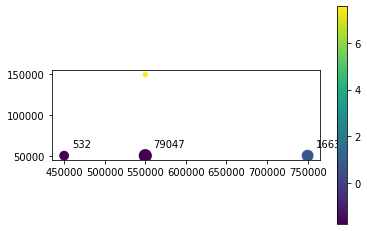

In [69]:
%matplotlib inline

fig, ax = plt.subplots()

#markersize = dfStats['regression.count']/100
markersize = (1-dfStats['regression.c.se'])*150
dfStats.plot(ax=ax, column='regression.c', markersize=markersize, legend=True)

for i, txt in enumerate(dfStats['regression.count']):
    ax.annotate(int(txt), (dfStats['gridCell.minX'][i]+(size/2)+10000, dfStats['gridCell.minY'][i]+(size/2)+10000))
    

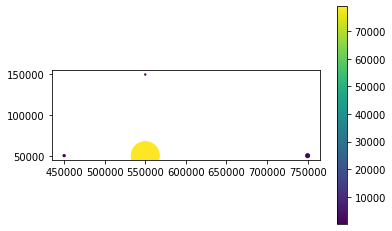

In [56]:
%matplotlib inline
markersize = dfStats['regression.count']/100
dfStats.plot(column='regression.count', markersize=markersize, legend=True)